In [6]:
"""
# GOES data Downloader

## Author(s)
Name: Savalan Naser Neisary
Email: savalan.neisary@gmail.com | snaserneisary@crimson.ua.edu
Affiliation: PhD Student, University of Alabama
GitHub: savalann

## Code Description
Creation Date: 2024-08-20
"""
import xarray as xr
import numpy as np
import geopandas as gpd
import os
from tqdm import tqdm
import time
import dask.array as da



In [12]:

# Import the necessary modules
from goes2go import GOES
import time

def goes_get(start_date, end_date, save_path, satellite_name, product_name, domain_name, bands_name, cpus):
    # Record the start time to measure the execution time of the script
    start_time = time.time()

    # Initialize a GOES object with the specified parameters
    G = GOES(satellite=satellite_name, product=product_name, domain=domain_name, bands=bands_name)

    # Use the timerange method of the GOES object to retrieve data within the specified date range
    # and save it to the specified directory, utilizing the specified number of CPUs
    data_info = G.timerange(start=start_date, end=end_date, save_dir=save_path, max_cpus=cpus)

    # Print the total run time of the script in hours and minutes
    print(f"Run Time: {int((time.time() - start_time) // 3600)} hours, {int(((time.time() - start_time) % 3600) // 60)} minutes")

    # Return the data information retrieved by the GOES object
    return data_info



/home/snaserneisary/snaserneisary/.conda/envs/goes_data_preparation/lib/python3.12/site-packages/goes2go/data.py:524: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  within=pd.to_timedelta(config["nearesttime"].get("within", "1H")),
/home/snaserneisary/snaserneisary/.conda/envs/goes_data_preparation/lib/python3.12/site-packages/goes2go/NEW.py:188: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  within=pd.to_timedelta(config["nearesttime"].get("within", "1H")),


In [13]:
def calc_latlon(ds, dataset_netcdf):
    """
    Calculate latitude and longitude coordinates for the dataset.
    The math for this function was taken from:
    https://makersportal.com/blog/2018/11/25/goes-r-satellite-latitude-and-longitude-grid-projection-algorithm

    Parameters:
    ds (xarray.Dataset): The dataset to add latitude and longitude coordinates.
    dataset_netcdf (xarray.Dataset): The reference NetCDF dataset.

    Returns:
    xarray.Dataset: The dataset with latitude and longitude coordinates added.
    """
    try:
        x = ds.x  # Get the x coordinates from the dataset
        y = ds.y  # Get the y coordinates from the dataset
        goes_imager_projection = dataset_netcdf.goes_imager_projection  # Get the projection information

        # Create a meshgrid for x and y
        x, y = np.meshgrid(x, y)

        # Extract projection attributes
        r_eq = goes_imager_projection.attrs["semi_major_axis"]
        r_pol = goes_imager_projection.attrs["semi_minor_axis"]
        l_0 = goes_imager_projection.attrs["longitude_of_projection_origin"] * (np.pi / 180)
        h_sat = goes_imager_projection.attrs["perspective_point_height"]
        H = r_eq + h_sat

        # Calculate latitude and longitude
        a = np.sin(x)**2 + (np.cos(x)**2 * (np.cos(y)**2 + (r_eq**2 / r_pol**2) * np.sin(y)**2))
        b = -2 * H * np.cos(x) * np.cos(y)
        c = H**2 - r_eq**2
        r_s = (-b - np.sqrt(b**2 - 4*a*c)) / (2*a)
        s_x = r_s * np.cos(x) * np.cos(y)
        s_y = -r_s * np.sin(x)
        s_z = r_s * np.cos(x) * np.sin(y)
        lat = np.arctan((r_eq**2 / r_pol**2) * (s_z / np.sqrt((H - s_x)**2 + s_y**2))) * (180 / np.pi)
        lon = (l_0 - np.arctan(s_y / (H - s_x))) * (180 / np.pi)

        print(np.nanmax(lon), np.nanmin(lon))
        print(np.nanmax(lat), np.nanmin(lat))

        # Assign the calculated lat/lon to the dataset
        ds = ds.assign_coords({
            "lat": (["y", "x"], lat),
            "lon": (["y", "x"], lon)
        })
        ds.lat.attrs["units"] = "degrees_north"
        ds.lon.attrs["units"] = "degrees_east"

        return ds
    except Exception as e:
        print(f"Error in calc_latlon: {e}")
        return None

def get_xy_from_latlon(ds, lats, lons):
    """
    Convert latitude and longitude bounds to x and y coordinates for slicing the data.

    Parameters:
    ds (xarray.Dataset): The dataset to extract x and y coordinates from.
    lats (tuple): Latitude bounds as (lat1, lat2).
    lons (tuple): Longitude bounds as (lon1, lon2).

    Returns:
    tuple: Two tuples containing the min and max x and y coordinates.
    """
    try:
        lat1, lat2 = lats  # Unpack latitude bounds
        lon1, lon2 = lons  # Unpack longitude bounds
        lat = ds.lat.data  # Get latitude data from the dataset
        lon = ds.lon.data  # Get longitude data from the dataset
        x = ds.x.data  # Get x coordinates from the dataset
        y = ds.y.data  # Get y coordinates from the dataset

        # Create a meshgrid for x and y
        x, y = np.meshgrid(x, y)

        # Filter x and y coordinates based on lat/lon bounds
        x = x[(lat >= lat1) & (lat <= lat2) & (lon >= lon1) & (lon <= lon2)]
        y = y[(lat >= lat1) & (lat <= lat2) & (lon >= lon1) & (lon <= lon2)]

        return ((min(x), max(x)), (min(y), max(y)))
    except Exception as e:
        print(f"Error in get_xy_from_latlon: {e}")
        return None, None

In [30]:
"""
# GOES data stacking

## Author(s)
Name: Savalan Naser Neisary
Email: savalan.neisary@gmail.com | snaserneisary@crimson.ua.edu
Affiliation: PhD Student, University of Alabama
GitHub: savalann

## Code Description
Creation Date: 2024-06-20
Description: This script stacks the GOES 16 data for daylight hours in California and Radiation variable in a Zarr file. It also can resample the data before saving it. 
## License
This software is licensed under the MIT. See the LICENSE file for more details.
"""

# Get the start time
print(f"Start Time: {int(time.time() // 3600)} hours")
start_time = time.time()

def data_stack(year=None, band=None, write_path=None, read_path=None, resample=False, resample_time=None):
    """
    Function to stack GOES 16 data for daylight hours in California and Radiation variable in a Zarr file.
    Optionally resamples the data before saving.

    Parameters:
    - year (str): The year of the data.
    - band (str): The band of the GOES data.
    - write_path (str): The path where the Zarr file will be saved.
    - read_path (str): The path where the GOES data is read from.
    - resample (bool): Whether to resample the data.
    - resample_time (str): The time frequency to resample the data.
    """
    print(f'Data Stacking for band {band} and year {year}')
    
    # Path to the parent folder containing the day folders
    parent_folder_path = read_path

    # Initialize an empty list to hold the combined "Rad" DataArrays for each day
    combined_rad_list = []

    # Loop through each day folder
    for day_folder in tqdm(os.listdir(parent_folder_path)):
        day_folder_path = os.path.join(parent_folder_path, day_folder)

        
        if not os.path.isdir(day_folder_path):
            continue
        
        # Loop through each hour folder within the day folder
        for hour_folder in os.listdir(day_folder_path):
            hour_folder_path = os.path.join(day_folder_path, hour_folder)
            
            if not os.path.isdir(hour_folder_path):
                continue
            
            if (15 <= int(hour_folder) <= 23):  # Filter for daylight hours
                # List all NetCDF files in the current hour folder
                netcdf_files = [f for f in os.listdir(hour_folder_path) if f.endswith('.nc')]
                
                # Initialize an empty list to hold the "Rad" DataArrays for the current hour
                rad_list = []

                # Loop through the NetCDF files and open each one
                for file in netcdf_files:
                    file_path = os.path.join(hour_folder_path, file)
                    dataset = xr.open_dataset(file_path, chunks={'time': 10})  # Use Dask by specifying chunks
                    
                    # Extract the "Rad" variable
                    rad_variable = dataset['Rad']
                    
                    # Append the "Rad" DataArray to the list for the current hour
                    rad_list.append(rad_variable)
                
                # Concatenate the "Rad" DataArrays along a new time dimension for the current hour
                if rad_list:
                    combined_rad_hour = xr.concat(rad_list, dim='time')
                    combined_rad_list.append(combined_rad_hour)

    # Concatenate all hourly combined "Rad" DataArrays into a single DataArray
    if combined_rad_list:
        final_combined_rad = xr.concat(combined_rad_list, dim='time')

        if resample:
            # Resample the data if requested
            final_combined_rad = final_combined_rad.sortby('t')
            final_combined_rad = final_combined_rad.isel(time=np.delete(np.arange(final_combined_rad.sizes['time']), 0))

            # Rename the coordinate if necessary to avoid conflicts
            final_combined_rad = final_combined_rad.rename({'t': 'time'})

            # Sort the dataset by the time coordinate
            final_combined_rad = final_combined_rad.sortby('time')
            # Resample the dataset over the time dimension (e.g., monthly mean)
            final_combined_rad = final_combined_rad.resample(time=f'1{resample_time}').mean()

    else:
        print("No 'Rad' data found in the specified folders.")
    
    # Print the total run time
    print(f"Run Time: {int((time.time() - start_time) // 3600)} hours, {int(((time.time() - start_time) % 3600) // 60)} minutes")
    return final_combined_rad



Start Time: 478991 hours


In [36]:

# Define the start and end dates for the data retrieval
start_date = '2020-06-01 00:00'
end_date = '2020-06-30 00:00'

# Specify the satellite, product, domain, and bands for the data retrieval
satellite_name = 'goes16'
product_name = "ABI-L1b-RadC"
domain_name = 'C'
bands_name = [1]

# Define the path where the retrieved data will be saved
save_path = '/home/snaserneisary/01.projects/2024_hackweek/data/'

# Set the number of CPUs to be used for the data retrieval process
cpus = 18


# Call the goes_get function with the specified parameters and store the returned data information
data_information = goes_get(start_date, end_date, save_path, satellite_name, product_name, domain_name, bands_name, cpus)

In [31]:
# %%
band = 1
year = 2020
write_path = '/home/snaserneisary/01.projects/2024_hackweek/data'
resample = 'False'
resample_time = 'D'
read_path = '/home/snaserneisary/01.projects/2024_hackweek/data'

# Call the data_stack function with the provided parameters
data = data_stack(year, band, write_path, read_path, resample, resample_time)

Data Stacking for band 1 and year 2020


100%|██████████| 87/87 [05:19<00:00,  3.67s/it]
/tmp/ipykernel_3405823/3971757755.py:90: UserWarning: rename 't' to 'time' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  final_combined_rad = final_combined_rad.rename({'t': 'time'})


Run Time: 0 hours, 6 minutes


/home/snaserneisary/snaserneisary/.conda/envs/goes_data_preparation/lib/python3.12/site-packages/dask/array/core.py:4832: PerformanceWarning: Increasing number of chunks by factor of 12
  result = blockwise(
/home/snaserneisary/snaserneisary/.conda/envs/goes_data_preparation/lib/python3.12/site-packages/dask/array/core.py:4832: PerformanceWarning: Increasing number of chunks by factor of 20
  result = blockwise(


In [32]:
data

<xarray.DataArray 'Rad' (time: 90, y: 3000, x: 5000)> Size: 5GB
dask.array<where, shape=(90, 3000, 5000), dtype=float32, chunksize=(3, 250, 250), chunktype=numpy.ndarray>
Coordinates:
  * y        (y) float32 12kB 0.1282 0.1282 0.1282 ... 0.04431 0.04428 0.04425
  * x        (x) float32 20kB -0.1013 -0.1013 -0.1013 ... 0.03857 0.0386 0.03863
  * time     (time) datetime64[ns] 720B 2020-04-01 2020-04-02 ... 2020-06-29
    y_image  float32 4B 0.08624
    x_image  float32 4B -0.03136
Attributes:
    long_name:              ABI L1b Radiances
    standard_name:          toa_outgoing_radiance_per_unit_wavelength
    sensor_band_bit_depth:  10
    valid_range:            [   0 1022]
    units:                  W m-2 sr-1 um-1
    resolution:             y: 0.000028 rad x: 0.000028 rad
    grid_mapping:           goes_imager_projection
    cell_methods:           t: point area: point
    ancillary_variables:    DQF

In [33]:
catchment = gpd.read_file('grand_mesa.geojson')
catchment = catchment.to_crs('EPSG:4326').dissolve()  # Convert the CRS and dissolve geometries
netcdf_files = [f for f in os.listdir(f'/home/snaserneisary/01.projects/2024_hackweek/data/092/00/') if f.endswith('.nc')]  # List NetCDF files
dataset_netcdf = xr.open_dataset(f'/home/snaserneisary/01.projects/2024_hackweek/data/092/00/{netcdf_files[0]}')  # Open a NetCDF file

ds_new = calc_latlon(data, dataset_netcdf)  # Calculate lat/lon for the data

geoms = np.array(catchment.geometry.bounds)[0]  # Get the catchment bounds
lats = (geoms[1], geoms[3])  # Extract latitude bounds
lons = (geoms[0], geoms[2])  # Extract longitude bounds
(x1, x2), (y1, y2) = get_xy_from_latlon(ds_new, lats, lons)  # Get x/y coordinates from lat/lon bounds

ds_new = ds_new.sel(x=slice(x1, x2), y=slice(y2, y1))  # Subset the dataset based on x/y coordinates

/tmp/ipykernel_3405823/4257533033.py:33: RuntimeWarning: invalid value encountered in sqrt
  r_s = (-b - np.sqrt(b**2 - 4*a*c)) / (2*a)


-52.93296 -151.81024
56.652508 14.566531


In [34]:
ds_new

<xarray.DataArray 'Rad' (time: 90, y: 34, x: 64)> Size: 783kB
dask.array<getitem, shape=(90, 34, 64), dtype=float32, chunksize=(3, 34, 64), chunktype=numpy.ndarray>
Coordinates:
  * y        (y) float32 136B 0.1052 0.1051 0.1051 ... 0.1043 0.1043 0.1042
  * x        (x) float32 256B -0.0715 -0.07147 -0.07144 ... -0.06976 -0.06973
  * time     (time) datetime64[ns] 720B 2020-04-01 2020-04-02 ... 2020-06-29
    y_image  float32 4B 0.08624
    x_image  float32 4B -0.03136
    lat      (y, x) float32 9kB 39.27 39.27 39.27 39.27 ... 38.75 38.75 38.75
    lon      (y, x) float32 9kB -108.7 -108.6 -108.6 ... -107.4 -107.4 -107.4
Attributes:
    long_name:              ABI L1b Radiances
    standard_name:          toa_outgoing_radiance_per_unit_wavelength
    sensor_band_bit_depth:  10
    valid_range:            [   0 1022]
    units:                  W m-2 sr-1 um-1
    resolution:             y: 0.000028 rad x: 0.000028 rad
    grid_mapping:           goes_imager_projection
    cell_methods:           t: point area: point
    ancillary_variables:    DQF

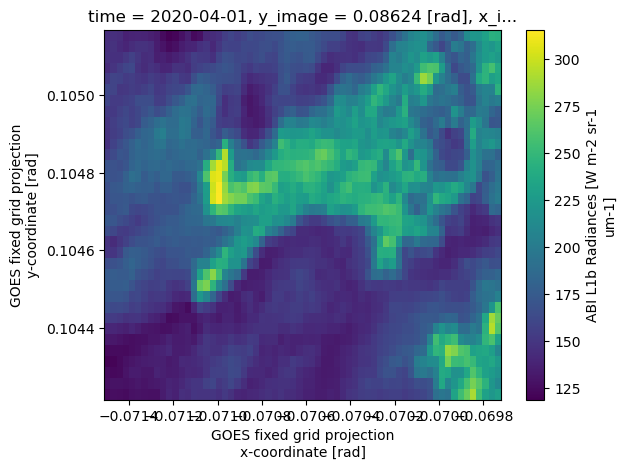

In [35]:
ds_new.isel(time=0).plot()